In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import ContrastiveWrapper

In [35]:
parser = get_parser()
args = parser.parse_args('''
--dataset UCI-HAR --batch_size 128 --window_size 48 --normalize --subjects_for_test 21 20 19 18 17 
--max_epochs 10 --lr 0.01 --training_dir training_clr --n_val_subjects 4 --reduce_imbalance
--encoder_architecture cnn_gap_ts --encoder_features 20 --cf 0.001 --label_mode 48 --mode clr3'''.split())

dm = load_dm(args)

Loaded dataset UCI-HAR with a total of 815614 observations for window size 48
Sampling 51608 (balanced) observations per epoch.
[4 4 4 ... 1 1 1] [ 0  1  2  3  4  5  6  7  8  9 10 11]
Using 646236 observations for training, 106617 for validation and 143333 observations for test


In [52]:
model = ContrastiveWrapper.load_from_checkpoint(checkpoint_path="training_clr/clr3_UCI-HAR_21-20-19-18-17_4_48_1_bs128_lr0.01_l10_l20_cnn_gap_ts20_mlpNone_1_m48/version_13/checkpoints/epoch=23-step=9696-val_re=0.0000.ckpt")

Input shape:  torch.Size([1, 6, 48])
Latent shape:  torch.Size([1, 80])


In [53]:
labels = []

for i in range(0, 5000):
    labels.append(dm.ds_test[i]["label"].item())

In [74]:
model=model.cuda()

In [75]:
scores = []
model.eval()
ws = 48
for i in range(0, 5000):
    prev = dm.ds_test[i]["series"]
    next_ = dm.ds_test[i+ws]["series"]

    prev_rep = model(prev.unsqueeze(0).cuda())
    next_rep = model(next_.unsqueeze(0).cuda())

    scores.append(((prev_rep-next_rep).square().sum()+1e-8 ).sqrt().item())

(-0.4968644431442954, 10.499850687768776)

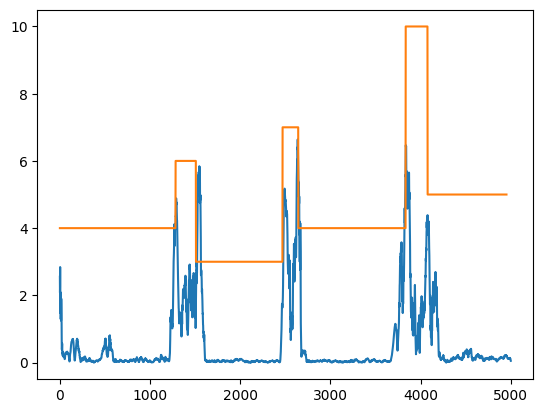

In [76]:
plt.plot(np.arange(len(scores)), scores, np.arange(len(labels)-48), labels[48:])
plt.ylim()

In [31]:
from pytorch_lightning import Trainer

In [32]:
tr = Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [111]:
tr.test(datamodule=dm, model=model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1120/1120 [00:04<00:00, 273.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_aupr           0.7197515368461609
       test_auroc           0.9698401093482971
        test_loss                   0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0,
  'test_auroc': 0.9698401093482971,
  'test_aupr': 0.7197515368461609}]

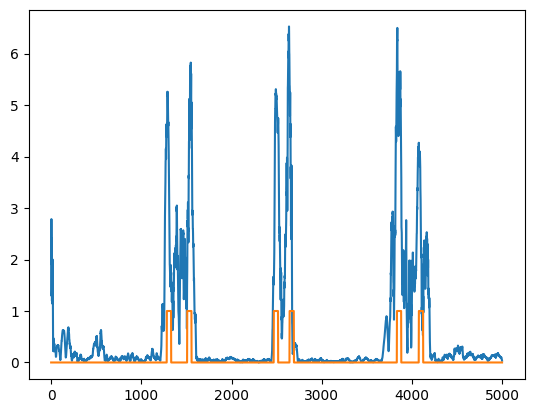

In [57]:
plt.plot(np.arange(5000), model.dissimilarities[:5000], np.arange(5000), model.labels_[:5000])

In [62]:
testdl = dm.val_dataloader()
enum_test = next(enumerate(testdl))

In [77]:
enum_test[1]["series"][:1].shape

torch.Size([1, 6, 48])

In [118]:
model = ContrastiveWrapper.load_from_checkpoint(checkpoint_path="training_clr/clr3_UCI-HAR_21-20-19-18-17_4_48_1_bs128_lr0.01_l10_l20_cnn_gap_ts20_mlpNone_1_m48/version_13/checkpoints/epoch=23-step=9696-val_re=0.0000.ckpt")

Input shape:  torch.Size([1, 6, 48])
Latent shape:  torch.Size([1, 80])


In [137]:
model.train()
model(enum_test[1]["series"][:1].cuda())

tensor([[ 0.1796, -0.0450, -0.1497, -0.1854, -0.1631, -0.0073,  0.2138,  1.0223,
          0.2624, -0.5311,  0.0384, -0.3065,  0.0120,  0.3781,  0.0616,  0.7031,
          0.2093, -0.1708, -0.1410, -0.0038,  0.0223, -0.0319, -0.3333,  0.6614,
          0.4418,  0.3470, -0.0367, -0.0687,  0.6106,  0.0101, -0.2662,  0.1027,
          0.2718, -0.1173, -0.0327, -0.1353,  0.1893, -1.1021, -0.2028,  0.0563]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [112]:
model.rpr[0]

tensor([-0.0133,  0.0989,  0.0600, -0.2420,  0.1946,  0.0726, -0.3323,  0.4263,
        -0.1734, -0.5044,  0.1439, -0.6528, -0.0228,  0.5864,  0.7714,  0.0368,
         0.0979,  0.4211,  0.1885,  0.0270,  0.0438, -0.1820, -0.6301,  2.1019,
         2.2882, -0.3771,  0.4702,  0.8453,  0.2820,  0.0313,  0.2423, -0.0657,
        -0.3007,  0.0782, -0.0420,  0.0032, -0.2475, -1.2966, -0.3305,  0.1052],
       device='cuda:0')